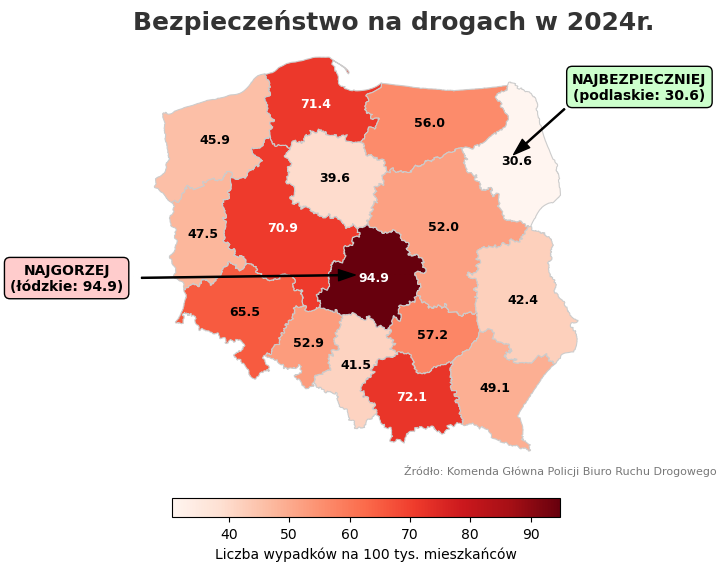

In [41]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


url_do_mapy = "https://raw.githubusercontent.com/ppatrzyk/polska-geojson/master/wojewodztwa/wojewodztwa-min.geojson"
mapa_pl = gpd.read_file(url_do_mapy).to_crs(epsg=2180) 

moje_dane = {
    'wojewodztwo': [
        'śląskie', 'mazowieckie', 'małopolskie', 'wielkopolskie', 
        'dolnośląskie', 'pomorskie', 'łódzkie', 'podkarpackie',
        'lubelskie', 'kujawsko-pomorskie', 'zachodniopomorskie',
        'warmińsko-mazurskie', 'świętokrzyskie', 'podlaskie',
        'lubuskie', 'opolskie'
    ],
    'liczba_wypadkow na 100 000 mieszkańców': [
        41.5, 52, 72.1, 70.9, 
        65.5, 71.4, 94.9, 49.1,
        42.4, 39.6, 45.9,
        56, 57.2, 30.6,
        47.5, 52.9
    ]
}
df_wypadki = pd.DataFrame(moje_dane)
col_name = 'liczba_wypadkow na 100 000 mieszkańców' 

mapa_z_danymi = mapa_pl.merge(df_wypadki, left_on='nazwa', right_on='wojewodztwo')


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mapa_z_danymi.plot(
    column=col_name,
    cmap='Reds',
    linewidth=0.8,
    edgecolor='0.8', 
    legend=True,
    legend_kwds={
        'label': "Liczba wypadków na 100 tys. mieszkańców", 
        'orientation': "horizontal", 
        'shrink': 0.4, 
        'pad': 0.05,
        'format': "%.0f"
    },
    ax=ax
)


ax.set_title('Bezpieczeństwo na drogach w 2024r.', loc='left', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#333333'})


ax.axis('off')


for idx, row in mapa_z_danymi.iterrows():
    wartosc = row[col_name]
    kolor_tekstu = 'white' if wartosc > 68 else 'black' 
    
    plt.annotate(
        text=f"{wartosc}", 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center',
        va='center', 
        fontsize=9,
        color=kolor_tekstu, 
        fontweight='bold'   
    )


row_min = mapa_z_danymi.loc[mapa_z_danymi[col_name].idxmin()]
row_max = mapa_z_danymi.loc[mapa_z_danymi[col_name].idxmax()]

def dodaj_strzalke(row, opis, kolor_tla, offset_x, offset_y):
    ax.annotate(
        text=f"{opis}\n({row['wojewodztwo']}: {row[col_name]})",
        xy=(row.geometry.centroid.x -10000, row.geometry.centroid.y + 5000),
        xytext=(row.geometry.centroid.x + offset_x, row.geometry.centroid.y + offset_y),
        arrowprops=dict(facecolor='black', shrink=0.05, width=0.8, headwidth=8),
        bbox=dict(boxstyle="round,pad=0.4", fc=kolor_tla, ec="black", alpha=1.0),
        fontsize=10,
        fontweight='bold',
        ha='center' 
    )

dodaj_strzalke(row_min, "NAJBEZPIECZNIEJ", "#ccffcc", 200000, 100000)
dodaj_strzalke(row_max, "NAJGORZEJ", "#ffcccc", -500000, -20000)

plt.figtext(0.85, 0.2, "Źródło: Komenda Główna Policji Biuro Ruchu Drogowego", ha="right", fontsize=8, color='#777777')

plt.tight_layout()
plt.show()

In [ ]:
# --- PRZELICZANIE NA TYSIĄCE (DZIELENIE) ---
# Tworzymy nowe listy podzielone przez 1000
y1 = [i / 1000 for i in l_wypadkow]
y2 = [i / 1000 for i in l_wypadkow_smiertelnych]

# --- USTAWIENIA STYLU ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Poprawa bezpieczeństwa na polskich drogach (2001-2024)', fontsize=20, fontweight='bold', y=1.05)

# --- WYKRES 1: WSZYSTKIE WYPADKI ---
ax1 = axs[0]
ax1.plot(rok, y1, color='#2980b9', linewidth=2, marker='o', markersize=4)
ax1.fill_between(rok, y1, color='#2980b9', alpha=0.1)

ax1.set_title('Całkowita liczba wypadków', fontsize=14, color='#2c3e50', pad=15)
ax1.set_ylim(0, 60) # <--- ZMIANA: Skala do 60
ax1.set_ylabel('Liczba wypadków [tys.]', fontsize=11) # <--- ZMIANA: Podpis jednostki
ax1.grid(axis='x', alpha=0)

# Etykiety start/stop (Wartości sformatowane do 1 miejsca po przecinku)
ax1.text(2001, y1[0] + 2, f'{y1[0]:.1f}', ha='center', color='#2980b9', fontweight='bold')
ax1.text(2024, y1[-1] + 2, f'{y1[-1]:.1f}', ha='center', color='#2980b9', fontweight='bold')

# Adnotacja spadku (Skorygowane współrzędne!)
spadek_proc1 = ((l_wypadkow[0] - l_wypadkow[-1]) / l_wypadkow[0]) * 100
ax1.annotate(f'Spadek o {spadek_proc1:.0f}%', 
             xy=(2024, y1[-1]),     # Współrzędne punktu (ok. 21.5)
             xytext=(2015, 50),     # Współrzędne tekstu (50, a nie 50000!)
             arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle="arc3,rad=-0.2"),
             fontsize=12, fontweight='bold', color='#2980b9')


# --- WYKRES 2: WYPADKI ŚMIERTELNE ---
ax2 = axs[1]
ax2.plot(rok, y2, color='#c0392b', linewidth=2, marker='o', markersize=4)
ax2.fill_between(rok, y2, color='#c0392b', alpha=0.1)

ax2.set_title('Liczba wypadków śmiertelnych', fontsize=14, color='#c0392b', pad=15)
ax2.set_ylim(0, 7) # <--- ZMIANA: Skala do 7 (tysięcy)
ax2.set_ylabel('Liczba ofiar [tys.]', fontsize=11)
ax2.grid(axis='x', alpha=0)

# Adnotacja spadku
spadek_proc2 = ((l_wypadkow_smiertelnych[0] - l_wypadkow_smiertelnych[-1]) / l_wypadkow_smiertelnych[0]) * 100
ax2.annotate(f'Spadek o {spadek_proc2:.0f}%', 
             xy=(2024, y2[-1]),    # ok. 1.8
             xytext=(2015, 6),     # Tekst na wysokości 6 (tysięcy)
             arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle="arc3,rad=-0.2"),
             fontsize=12, fontweight='bold', color='#c0392b')

# Etykiety start/stop
ax2.text(2001, y2[0] + 0.3, f'{y2[0]:.2f}', ha='center', color='#c0392b', fontweight='bold')
ax2.text(2024, y2[-1] + 0.3, f'{y2[-1]:.2f}', ha='center', color='#c0392b', fontweight='bold')

# Wspólne ustawienia dla obu osi
for ax in axs:
    ax.set_xlabel('Rok', fontsize=10, color='gray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

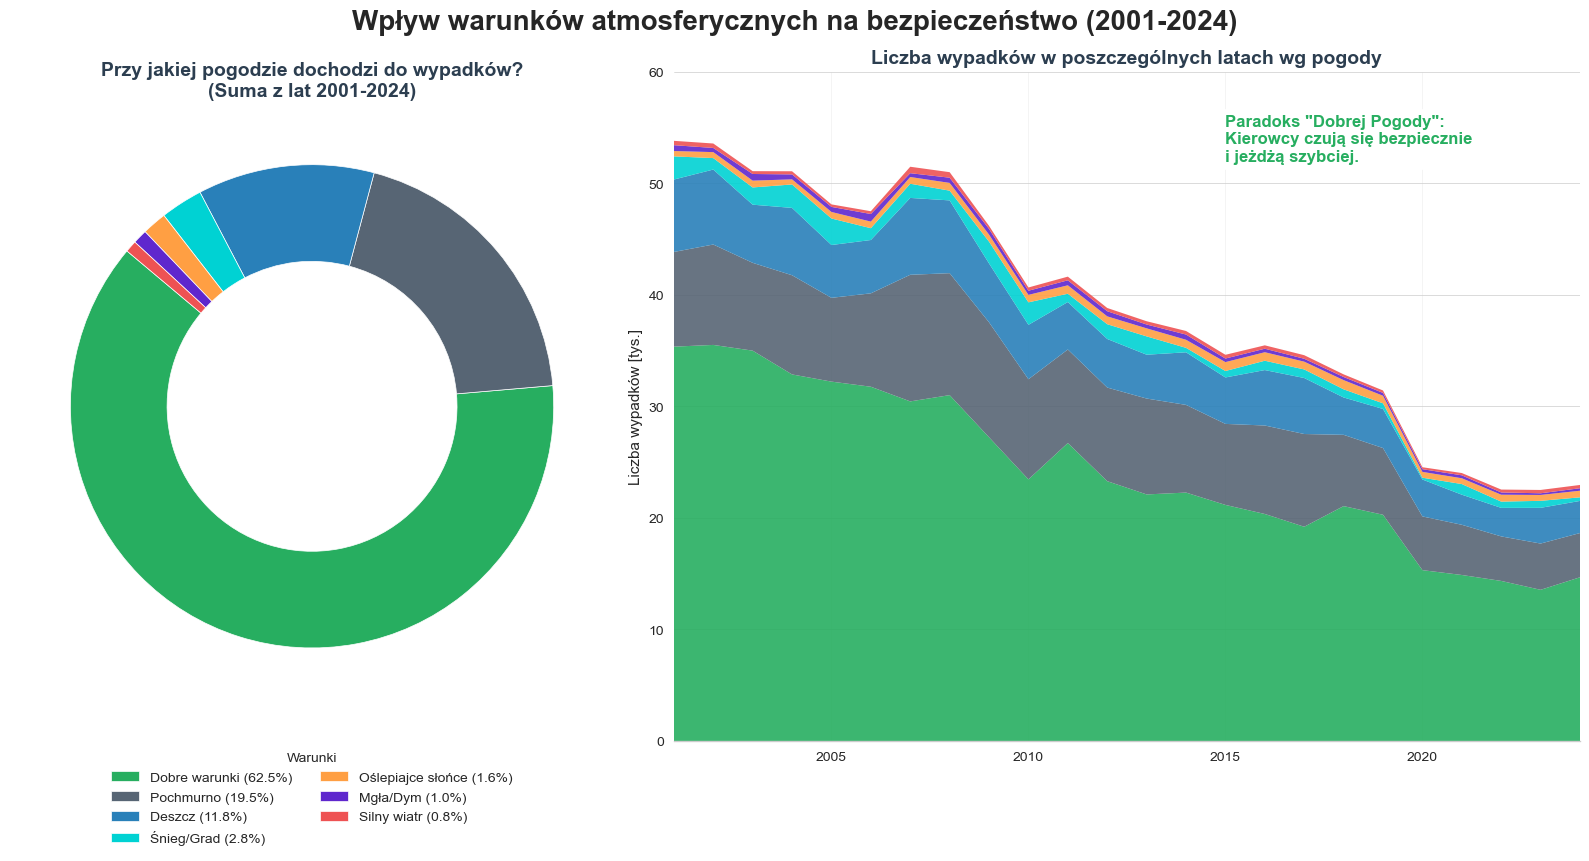

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

dane = {
    'Rok' : [2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024],
    'Dobre warunki' : [35348,35503,34990,32858,32214,31755,30441,31003,27226,23452,26710,23290,22102,22268,21162,20349,19205,21055,20281,15316,14881,14349,13552,14676],
    'Oślepiajce słońce' : [479,536,611,456,586,591,603,695,635,669,756,705,720,724,798,762,698,825,679,522,520,621,527,592],
    'Silny wiatr':[391,399,253,281,225,250,577,495,279,292,329,290,294,320,336,304,320,236,219,173,205,260,298,293],
    'Pochmurno' : [8488,9000,7872,8890,7510,8372,11349,10931,10303,8973,8384,8392,8595,7859,7262,7931,8312,6390,5978,4815,4500,3991,4146,3965],
    'Deszcz' :[6490,6719,5212,6037,4735,4780,6889,6524,5276,4878,4254,4354,3929,4715,4162,4969,5020,3348,3504,3309,2698,2557,3202,2878],
    'Śnieg/Grad' : [2078,1028,1544,2102,2376,1059,1272,873,1952,2017,743,1323,1643,399,579,837,768,730,505,160,953,560,628,323],
    'Mgła/Dym' : [523,373,596,445,454,680,343,466,505,371,448,460,343,468,319,315,259,281,254,244,263,200,150,224]
}

df = pd.DataFrame(dane)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'

mapa_kolorow = {
    'Dobre warunki': '#27ae60',     
    'Pochmurno': '#576574',         
    'Deszcz': '#2980b9',            
    'Śnieg/Grad': '#00d2d3',        
    'Oślepiajce słońce': '#ff9f43', 
    'Mgła/Dym': '#5f27cd',          
    'Silny wiatr': '#ee5253'        
}

kolumny_pogoda = list(df.columns[1:])
sumy_series = df[kolumny_pogoda].sum()
sumy_sorted = sumy_series.sort_values(ascending=False)

etykiety_sorted = sumy_sorted.index.tolist()
kolory_sorted = [mapa_kolorow[etykieta] for etykieta in etykiety_sorted]
total_wypadki = sumy_sorted.sum()
etykiety_z_procentami = [f"{label} ({val/total_wypadki*100:.1f}%)" for label, val in zip(etykiety_sorted, sumy_sorted)]



fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.5])


ax1 = fig.add_subplot(gs[0])

wedges, texts = ax1.pie(
    sumy_sorted, 
    labels=None, 
    startangle=140,
    colors=kolory_sorted, 
    wedgeprops=dict(width=0.4, edgecolor='white')
)

ax1.set_title('Przy jakiej pogodzie dochodzi do wypadków?\n(Suma z lat 2001-2024)', fontsize=14, fontweight='bold', color='#2c3e50')
ax1.legend(wedges, etykiety_z_procentami, title="Warunki", loc="center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)



ax2 = fig.add_subplot(gs[1])


ax2.stackplot(
    df['Rok'], 
    [df[col] / 1000 for col in etykiety_sorted], 
    labels=etykiety_sorted,
    colors=kolory_sorted,
    alpha=0.9
)

ax2.set_title('Liczba wypadków w poszczególnych latach wg pogody', fontsize=14, fontweight='bold', color='#2c3e50')
ax2.set_xlim(2001, 2024)


ax2.set_ylim(0, 60) 


ax2.set_ylabel('Liczba wypadków [tys.]', fontsize=11)

ax2.grid(axis='x', alpha=0.3)


ax2.text(x=2015, y=52, 
         s='Paradoks "Dobrej Pogody":\nKierowcy czują się bezpiecznie\ni jeżdżą szybciej.',
         fontsize=12, fontweight='bold', color='#27ae60', 
         backgroundcolor='white', ha='left')

sns.despine(ax=ax2, left=True)

plt.suptitle('Wpływ warunków atmosferycznych na bezpieczeństwo (2001-2024)', fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [97]:
dane={
    'Rok' : [2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024],
    'Dobre warunki' : [35348,35503,34990,32858,32214,31755,30441,31003,27226,23452,26710,23290,22102,22268,21162,20349,19205,21055,20281,15316,14881,14349,13552,14676],
    'Oślepiajce słońce' : [479,536,611,456,586,591,603,695,635,669,756,705,720,724,798,762,698,825,679,522,520,621,527,592],
    'Silny wiatr':[391,399,253,281,225,250,577,495,279,292,329,290,294,320,336,304,320,236,219,173,205,260,298,293],
    'Pochmurno' : [8488,9000,7872,8890,7510,8372,11349,10931,10303,8973,8384,8392,8595,7859,7262,7931,8312,6390,5978,4815,4500,3991,4146,3965],
    'Deszcz' :[6490,6719,5212,6037,4735,4780,6889,6524,5276,4878,4254,4354,3929,4715,4162,4969,5020,3348,3504,3309,2698,2557,3202,2878],
    'Śnieg/Grad' : [2078,1028,1544,2102,2376,1059,1272,873,1952,2017,743,1323,1643,399,579,837,768,730,505,160,953,560,628,323],
    'Mgła/Dym' : [523,373,596,445,454,680,343,466,505,371,448,460,343,468,319,315,259,281,254,244,263,200,150,224]
}